In [115]:
STUDENTDATAFILE = 'creditos_banco_alumnos.csv'
EVALDATAFILE    = 'creditos_banco_evaluacion.csv'
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np


In [116]:
df = pd.read_csv(STUDENTDATAFILE)
df.head()

,Importe,añosPago,IngresoAnuales,RelacionIngresoDeuda,RelacionCuotaDeuda,PendienteEnTarjeta,UsoCreditoTarjeta,Objetivo,esPropietario,FueVeraz,TuvoEmbargo,Cuentas,PuntuacionGeneral,Default,AntiguedadLaboral
0,2000,3,37000,6.29,2.22551,9663,96.6,Deuda,Hipoteca,0,0,2,4.4,paid off,2
1,28625,5,64000,15.34,14.07690,20084,60.3,Deuda renovable,Hipoteca,0,0,18,3.8,paid off,3
2,10400,3,76000,15.11,5.71753,4808,40.1,Deuda,Alquiler,0,1,8,4.4,paid off,7
3,33425,5,75000,20.85,14.08580,25807,60.7,Deuda,Hipoteca,0,1,14,4.0,paid off,11
4,15000,5,55000,7.66,9.43025,8452,49.4,Deuda,Alquiler,1,1,10,1.4,default,4


In [117]:
print(df.isnull().sum()/len(df)*100)
# no hay  nulos, no se imputa

# verificar unicos
print(df.nunique()/len(df)*100)
# no hay cantidad significativa de verificar unicos en no numericos

Importe                 0.0
añosPago                0.0
IngresoAnuales          0.0
RelacionIngresoDeuda    0.0
RelacionCuotaDeuda      0.0
PendienteEnTarjeta      0.0
UsoCreditoTarjeta       0.0
Objetivo                0.0
esPropietario           0.0
FueVeraz                0.0
TuvoEmbargo             0.0
Cuentas                 0.0
PuntuacionGeneral       0.0
Default                 0.0
AntiguedadLaboral       0.0
dtype: float64
Importe                  3.072987
añosPago                 0.005881
IngresoAnuales          12.465447
RelacionIngresoDeuda    10.127625
RelacionCuotaDeuda      89.925307
PendienteEnTarjeta      60.971593
UsoCreditoTarjeta        3.114156
Objetivo                 0.035288
esPropietario            0.011763
FueVeraz                 0.005881
TuvoEmbargo              0.005881
Cuentas                  0.138211
PuntuacionGeneral        0.102923
Default                  0.005881
AntiguedadLaboral        0.035288
dtype: float64


In [118]:
# fig, axs = plt.subplots(1, len(df.columns), figsize=(8, 3))
# for c,i in zip(df.columns, range(len(df.columns))):
#     axs[i].boxplot(df[c])
   
# plt.tight_layout()
# plt.show()

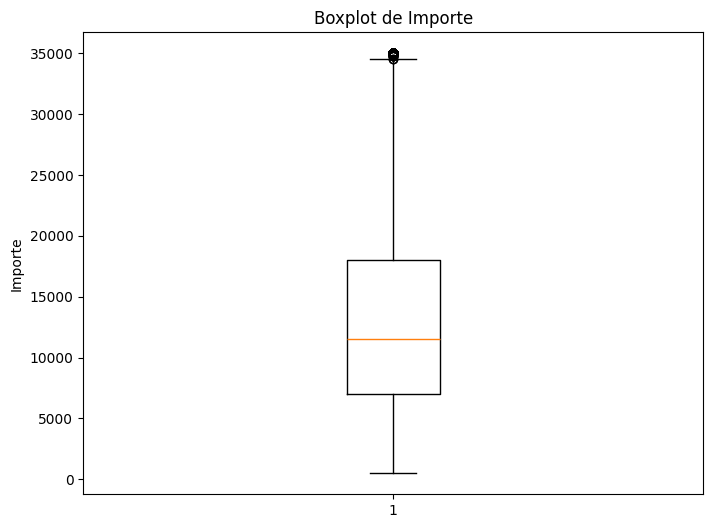

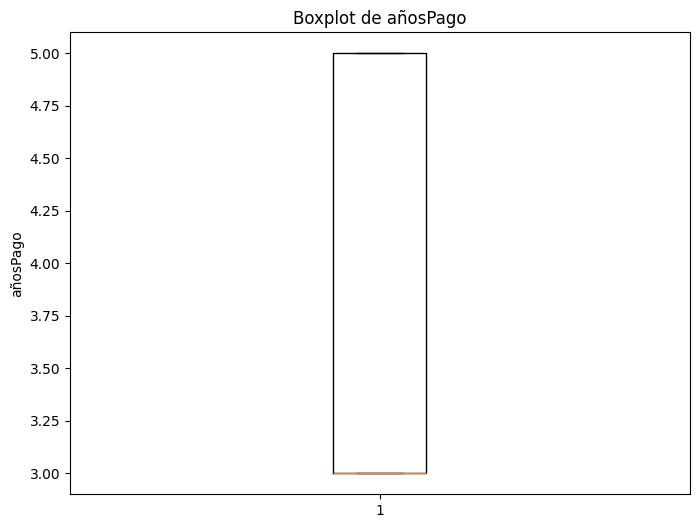

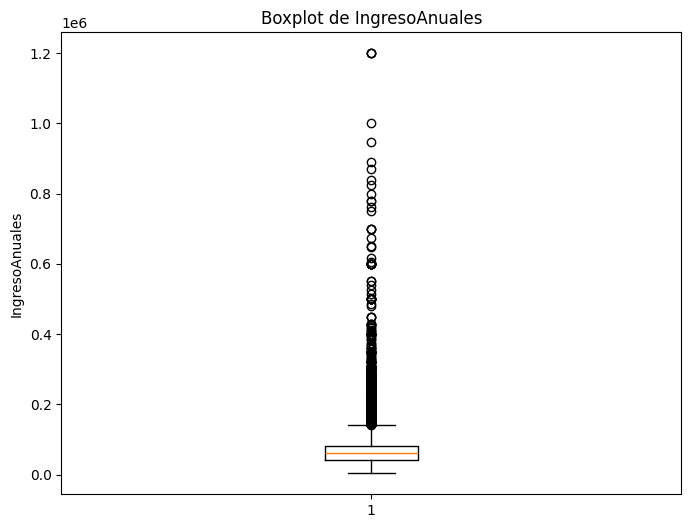

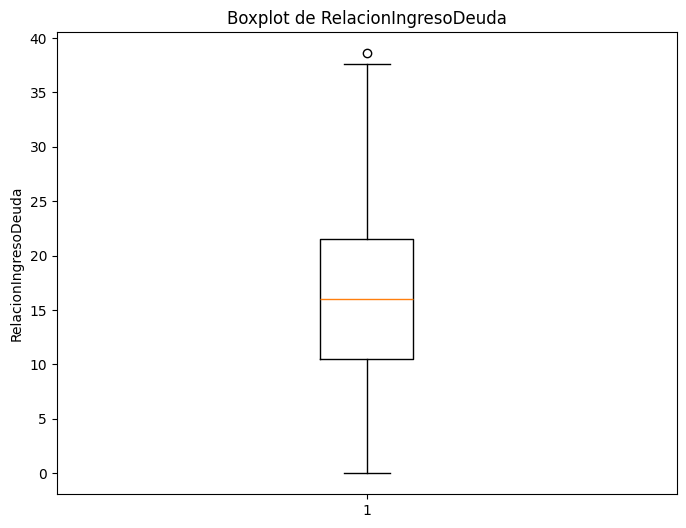

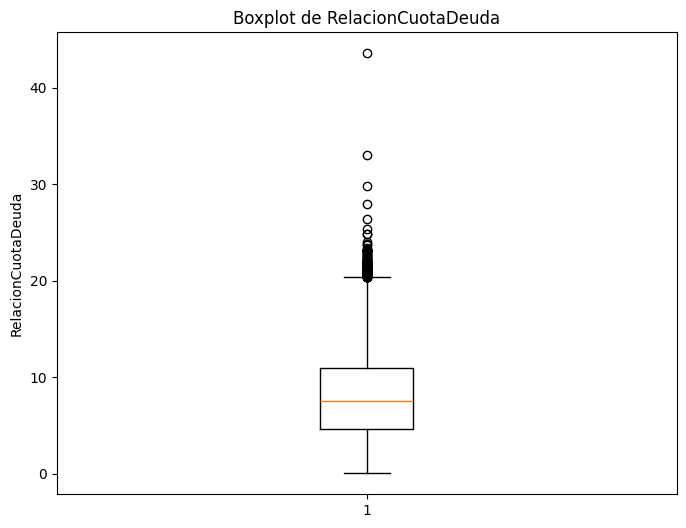

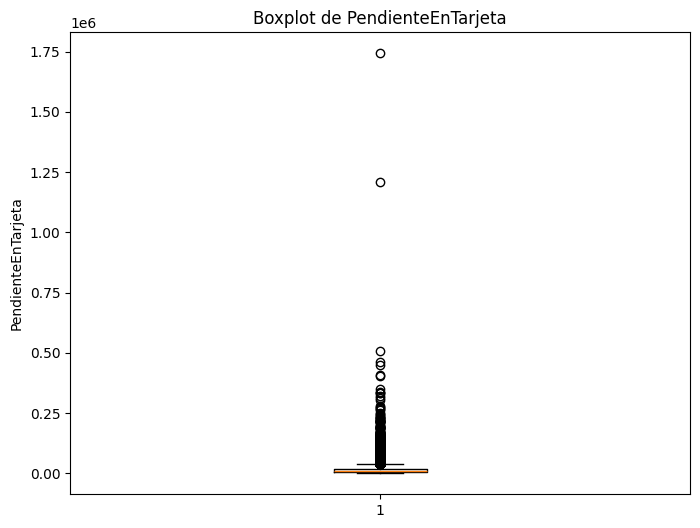

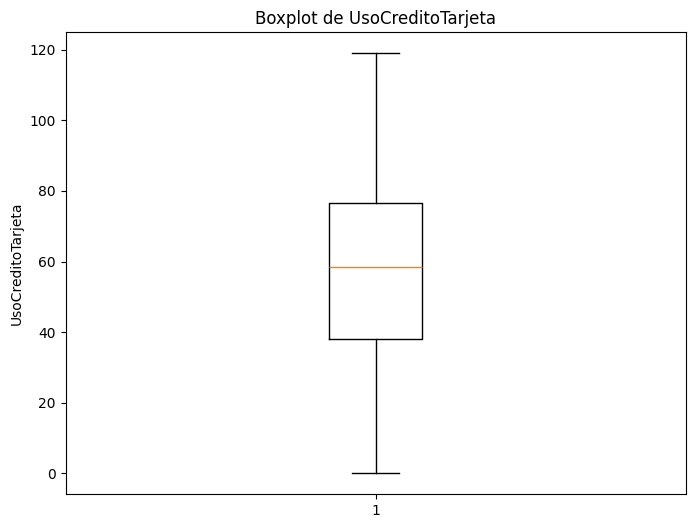

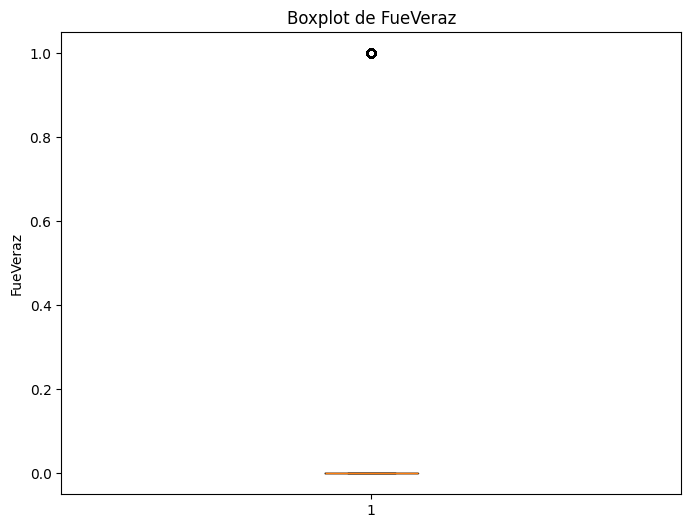

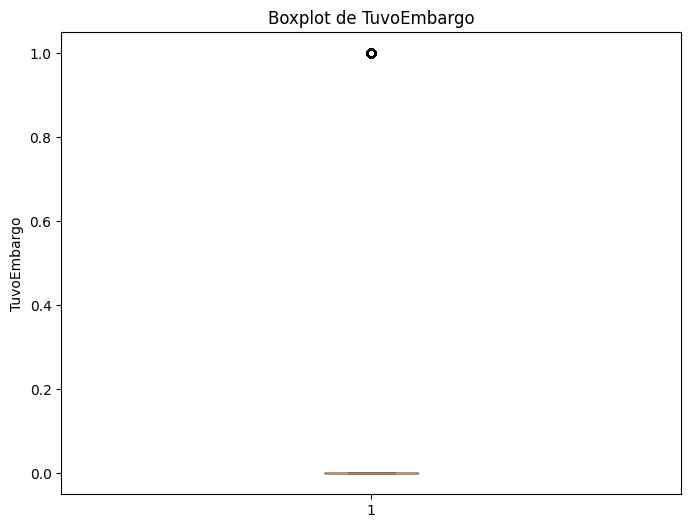

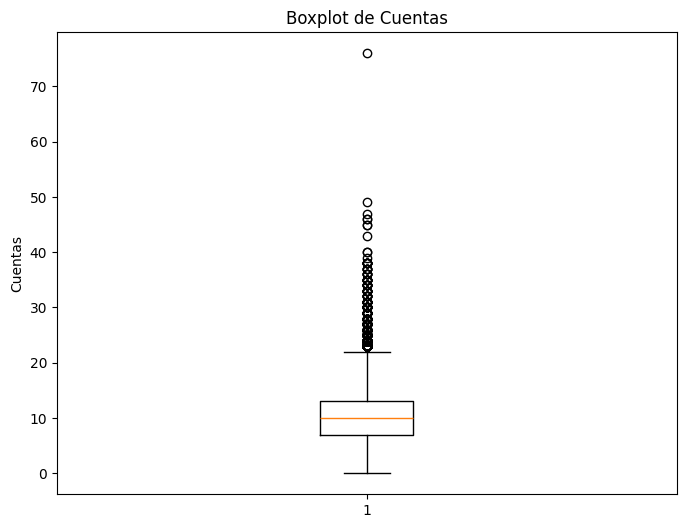

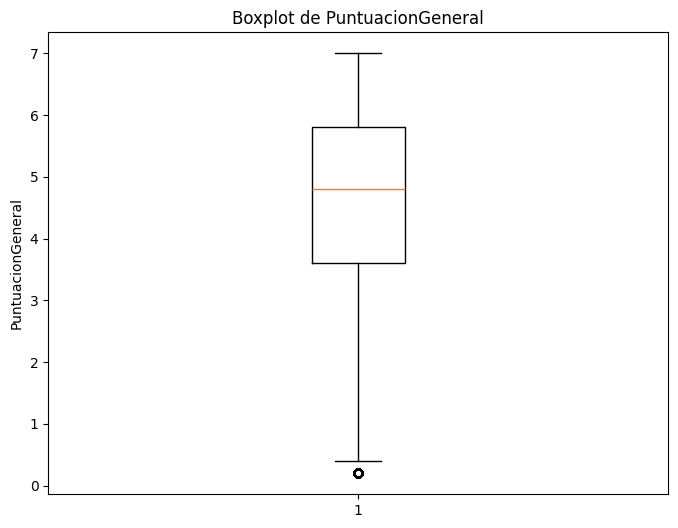

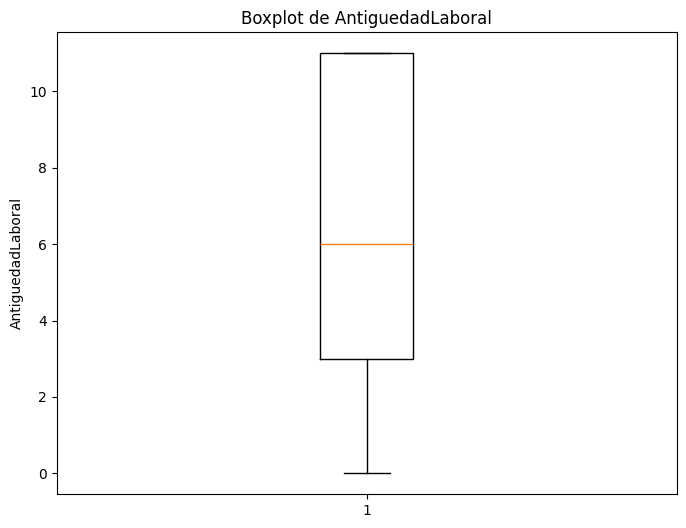

In [119]:
numeric_columns = df.select_dtypes(include=np.number).columns
for column in numeric_columns:
    plt.figure(figsize=(8, 6))
    plt.boxplot(df[column].dropna())  # Evitar NaN en el boxplot
    plt.title(f'Boxplot de {column}')
    plt.ylabel(column)
    plt.show()

In [121]:
# importante en "~"
df_numeric = df.select_dtypes(include=np.number)
df_numeric.drop(columns=["FueVeraz"], inplace=True)
df_numeric.drop(columns=["TuvoEmbargo"], inplace=True)

Q1 = df_numeric.quantile(0.25)  # Primer cuartil (Q1)
Q3 = df_numeric.quantile(0.75)  # Tercer cuartil (Q3)
IQR = Q3 - Q1  # Rango intercuartil
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df_numeric[~((df_numeric < lower_bound) | (df_numeric > upper_bound)).any(axis=1)]
print(df.head())

   Importe  añosPago  IngresoAnuales  RelacionIngresoDeuda  \
0     2000         3           37000                  6.29   
1    28625         5           64000                 15.34   
2    10400         3           76000                 15.11   
3    33425         5           75000                 20.85   
4    15000         5           55000                  7.66   

   RelacionCuotaDeuda  PendienteEnTarjeta  UsoCreditoTarjeta  Cuentas  \
0             2.22551                9663               96.6        2   
1            14.07690               20084               60.3       18   
2             5.71753                4808               40.1        8   
3            14.08580               25807               60.7       14   
4             9.43025                8452               49.4       10   

   PuntuacionGeneral  AntiguedadLaboral  
0                4.4                  2  
1                3.8                  3  
2                4.4                  7  
3                4.0

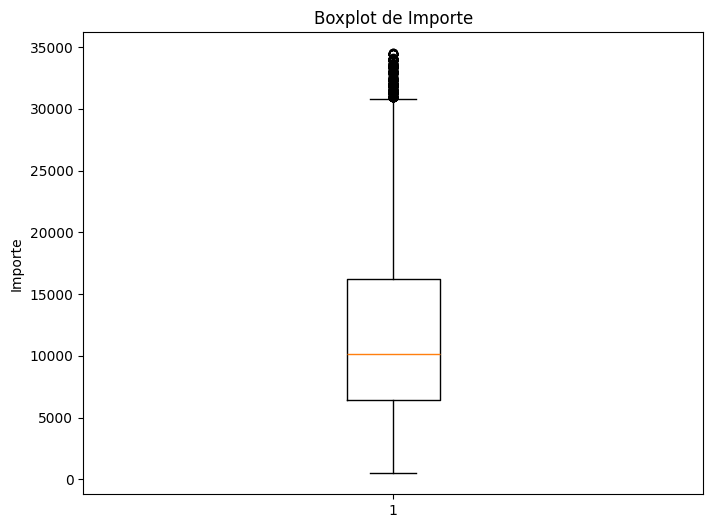

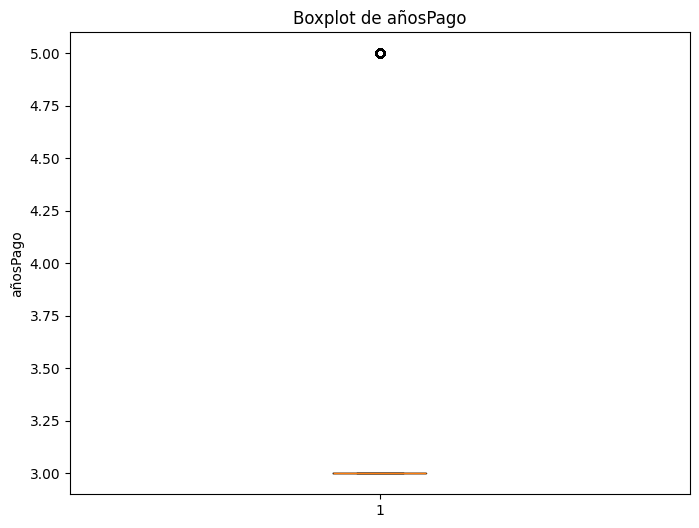

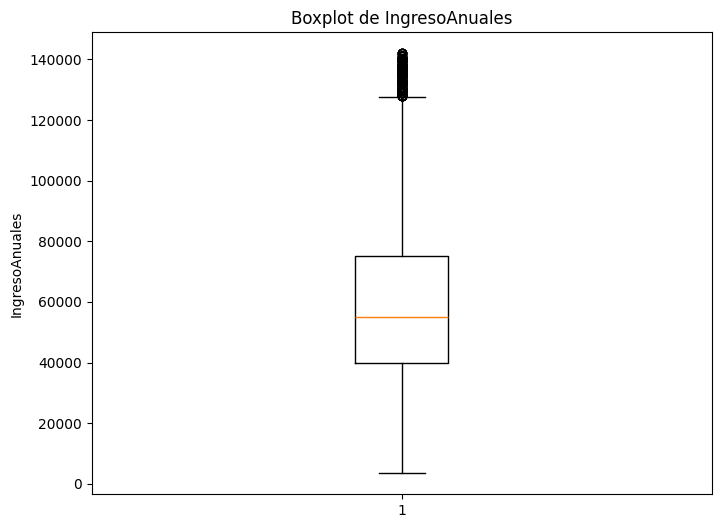

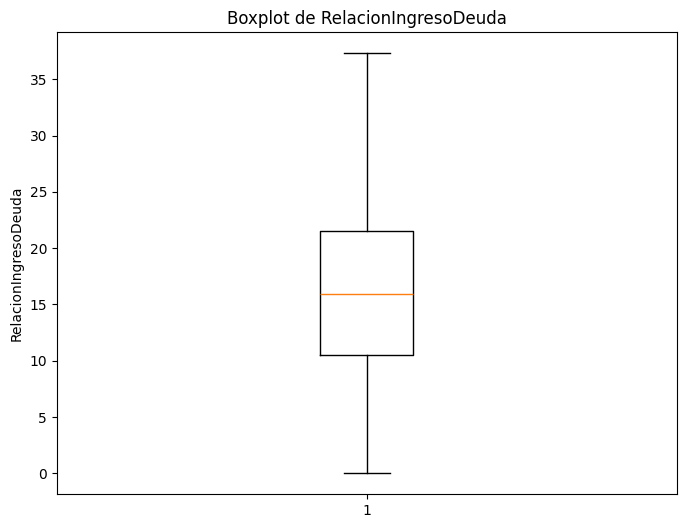

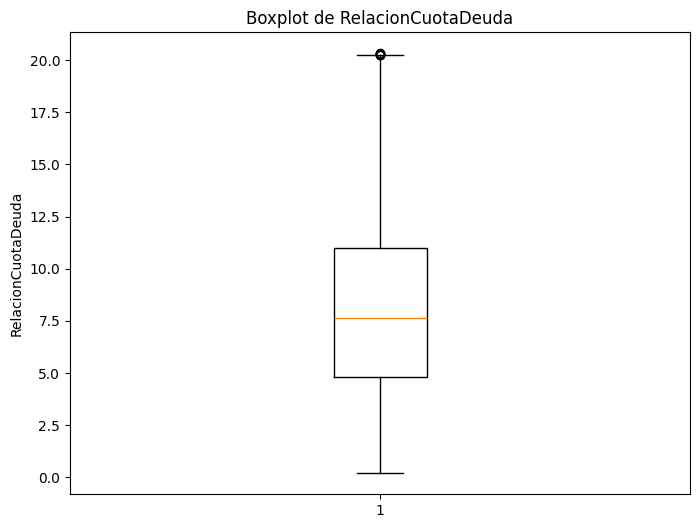

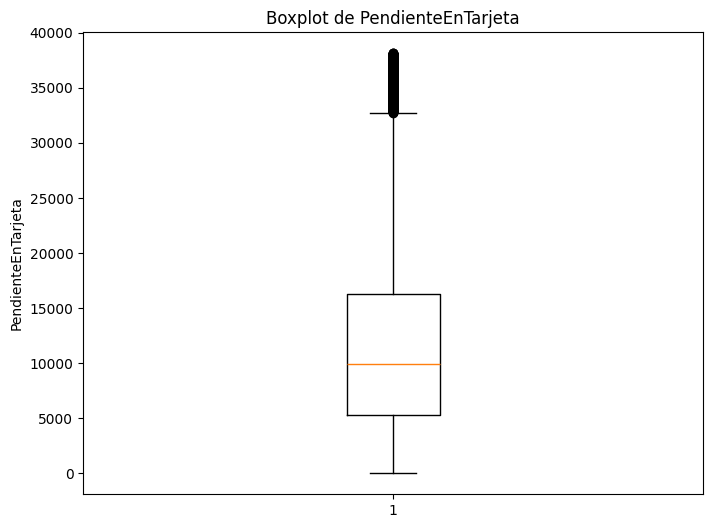

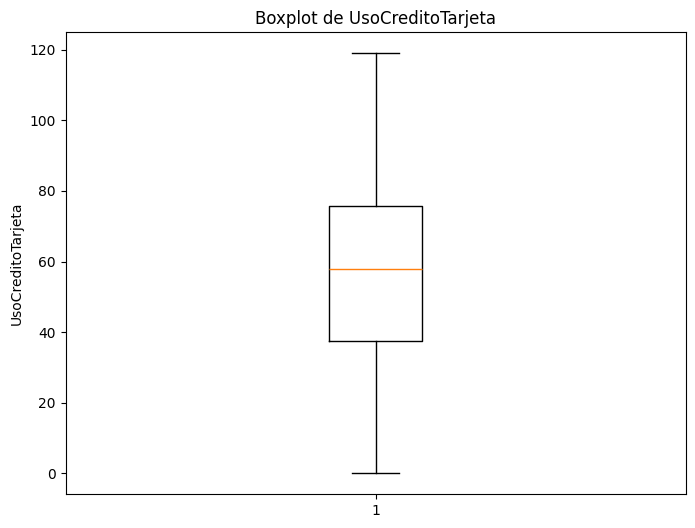

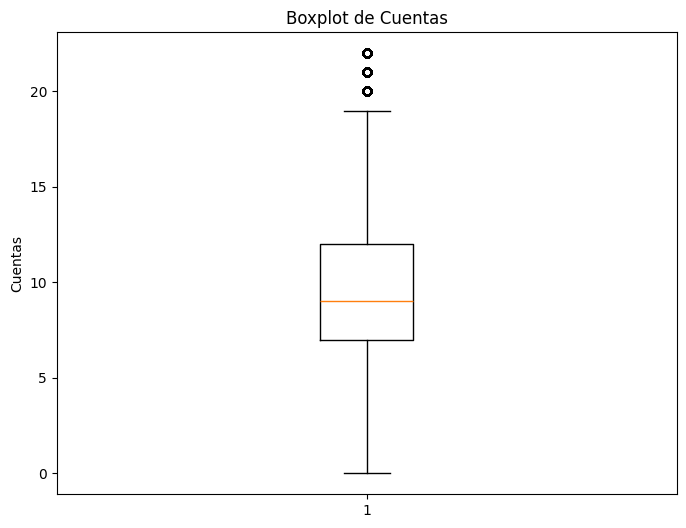

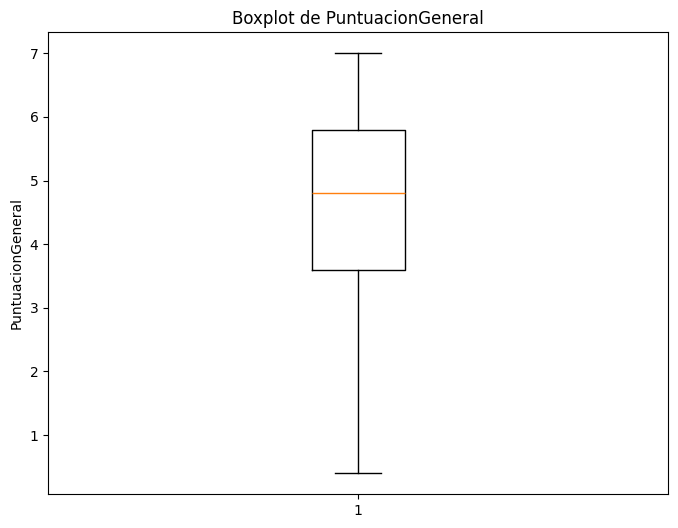

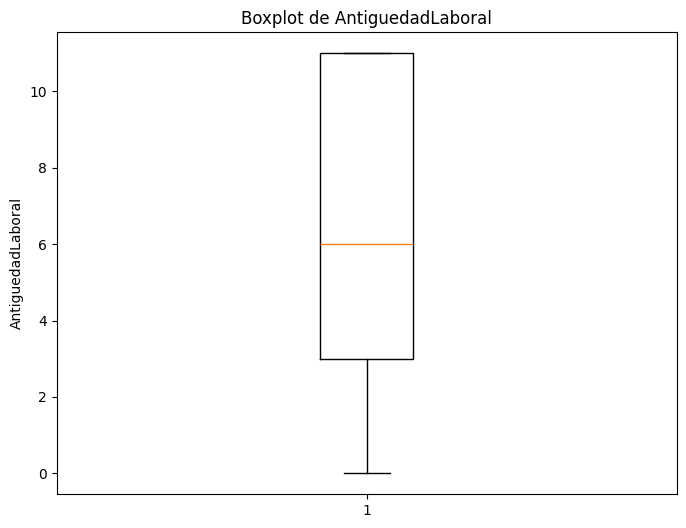

In [122]:
for column in df_numeric.columns:
    plt.figure(figsize=(8, 6))
    plt.boxplot(df[column].dropna())  # Evitar NaN en el boxplot
    plt.title(f'Boxplot de {column}')
    plt.ylabel(column)
    plt.show()


In [ ]:


# numerical_features = ['Age', 'Fare', 'Parch', 'SibSp']
# categorical_features = ['Pclass', 'Sex', 'Embarked']


# numerical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore')) 
# ])